In [1]:
import pandas as pd 
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pickle
from matplotlib import pyplot as plt

# Chargement des données

In [2]:
digits = pd.read_csv("./data-csv/train.csv")
digits.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
y = digits["label"]
x = digits[digits.columns.drop("label")]

# Analyse

In [4]:
# evaluation du nombre de données par modélisation (ex: il y a 4684 lignes avec le label 1)
digits['label'].value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

# Découpage du jeu de données (futur modèle)

In [5]:
# reparti le set entre un set de train et un set de test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y, random_state=42)

In [6]:
# nombre de fois où un label est utilisé dans l'entrainement
y_train.value_counts()

1    3138
7    2949
3    2915
9    2806
2    2799
6    2772
0    2768
4    2728
8    2722
5    2543
Name: label, dtype: int64

In [7]:
# nombre de fois où un label est utilisé dans l'entrainement
y_test.value_counts()

1    1546
7    1452
3    1436
9    1382
2    1378
6    1365
0    1364
4    1344
8    1341
5    1252
Name: label, dtype: int64

In [8]:
# on remarque que y_train.value_counts() + y_test.value_counts() = digits['label'].value_counts()
# la division du set a donc été effectuée correctement 
y_train.value_counts() + y_test.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

# Entrainement du modèle et prediction

In [9]:
depth = range(2,50)
errors = []
err_default = 15

for d in depth:
    modelDecisionTreeClassifier = tree.DecisionTreeClassifier(max_depth=d)
    modelDecisionTreeClassifier = modelDecisionTreeClassifier.fit(x_train, y_train)

    err = round((1.0 - modelDecisionTreeClassifier.score(x_test, y_test)) * 100, 3)
    errors.append(err)
    #print(f"\n\nResults : decision tree = {modelDecisionTreeClassifier.get_depth()} => err_test = {err}\n")
    #print(f'Improvement of {-(err - err_default)}%\n\n')

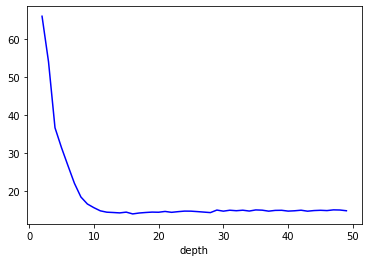

In [10]:
# evolution du taux d'erreurs par rapport au niveau de profondeur
plt.plot(depth, errors, 'b')
plt.xlabel('depth')
plt.show()

# Entrainement et prédiction optimals 

In [11]:
# entrainement du modèle 
OPTIMUM_DEPTH = 12
modelDecisionTreeClassifier = tree.DecisionTreeClassifier(max_depth=OPTIMUM_DEPTH)
modelDecisionTreeClassifier = modelDecisionTreeClassifier.fit(x_train, y_train)

In [12]:
# prediction sur x_test
y_prediction = modelDecisionTreeClassifier.predict(x_test)

In [13]:
# affichage prédiction
y_prediction

array([9, 6, 5, ..., 5, 0, 6])

In [14]:
# set d'origine
y_test

3467     9
36891    6
33659    5
20365    6
8340     0
        ..
29853    5
6166     9
8253     5
27736    0
40623    5
Name: label, Length: 13860, dtype: int64

# Retour sur expérience - pourcentage d'erreur

In [15]:
conf_mat = confusion_matrix(y_test, y_prediction)

In [16]:
acc = conf_mat.diagonal().sum()/conf_mat.sum()

In [17]:
err = 1 - acc
print("taux d'erreur:", err * 100)

taux d'erreur: 14.494949494949495


# Sauvegarde du modèle

In [18]:
filename = "./digit_recognizer.sav"

pickle.dump(modelDecisionTreeClassifier, open(filename, 'wb'))